# Importing Libraries

In [7]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [8]:
# %run "Git.ipynb".ipynb

In [9]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [12]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [13]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [15]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [16]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [17]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [18]:
# trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))


In [19]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [20]:
price

,Date(UTC),Market,Type,Price,Amount,Total,Fee,Fee Coin,Pair Price,Price in USDT,Total in USDT,Pair Quantity
0,2025-08-09 00:37:56,BBBNB,SELL,0.000163,116.400000,0.018985,0.000014,BNB,794.62000000,0.129603,15.085734,116.400000
1,2024-09-25 15:25:35,OMUSDT,BUY,1.180300,57.000000,67.277100,0.057000,OM,1.17990000,1.180300,67.277100,57.000000
2,2024-09-25 15:25:35,OMUSDT,BUY,1.180300,34.000000,40.130200,0.034000,OM,1.17990000,1.180300,40.130200,34.000000
3,2024-09-25 15:25:35,OMUSDT,BUY,1.180200,94.000000,110.938800,0.094000,OM,1.17990000,1.180200,110.938800,94.000000
4,2024-09-25 15:25:00,TRXUSDT,SELL,0.150800,1456.100000,219.579880,0.219580,USDT,0.15080000,0.150800,219.579880,1456.100000
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2024-05-09 22:32:57,TRXEUR,BUY,0.118983,205.828142,25.000000,0.510000,EUR,1.07790000,0.128252,26.397772,205.828142
76,2024-05-09 19:36:50,UMAEUR,BUY,3.803499,6.438808,25.000000,0.510000,EUR,1.07750000,4.098270,26.387975,6.438808
77,2024-05-06 23:27:11,ETHEUR,BUY,2912.268956,0.008407,25.000000,0.510000,EUR,1.07600000,3133.601397,26.344908,0.008407
78,2024-05-06 23:15:38,BTCEUR,BUY,59899.712723,0.000409,25.000000,0.510000,EUR,1.07610000,64458.080861,26.353686,0.000409


In [21]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [22]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_47316\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [23]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [24]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [25]:
book_cost.iloc[-1]

LPTUSDT         23.209038
TNSRUSDT         0.860996
ARUSDT                NaN
PEPEUSDT         0.000015
OMUSDT           1.129914
USDTUSDT         0.000011
FETUSDT          2.292907
BNBUSDT        680.981177
RNDRUSDT        11.186443
TRXUSDT          0.158366
EURUSDT          1.083068
INJUSDT               NaN
ENSUSDT         23.729381
BTCUSDT      70298.808206
NEARUSDT         8.272700
SOLUSDT        157.056383
MKRUSDT       2786.582522
NOTUSDT          0.019619
ETHUSDT       3654.535009
BBUSDT           0.516922
JASMYUSDT        0.030287
UMAUSDT          4.098270
XRPUSDT          0.551117
Name: 2025-08-09 00:37:56, dtype: float64

In [26]:
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2261.97,2099.63,1.00,-100.45,-61.89,-162.34,-7.18
BTCUSDT,622.20,994.31,0.47,2.81,372.11,374.92,16.57
SOLUSDT,281.20,323.48,0.15,0.00,42.28,42.28,1.87
ETHUSDT,253.39,292.74,0.14,0.00,39.35,39.35,1.74
JASMYUSDT,387.46,191.64,0.09,0.00,-195.82,-195.82,-8.66
TRXUSDT,76.87,171.29,0.08,-12.30,94.42,82.12,3.63
OMUSDT,526.32,108.81,0.05,0.00,-417.51,-417.51,-18.46
BNBUSDT,14.08,17.36,0.01,-10.65,3.28,-7.37,-0.33
BBUSDT,0.01,0.00,0.00,-84.82,-0.00,-84.82,-3.75
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.70


In [44]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

129

In [40]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [42]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [43]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [44]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [45]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [46]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [48]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 8ace0a42f2ae494704aad5ababcde363b6454c60)
✅ File pushed/updated successfully!


In [55]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [57]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [59]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [61]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: db9967bfd4b24fa1c9fce9452e2ec941e4085c50)
✅ File pushed/updated successfully!


In [62]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [65]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [67]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [69]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [71]:
# pnl_history['Total']

In [73]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [99]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [101]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [103]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)#+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [105]:
pnl_history['Total']

2024-09-23   -260.527866
2024-09-24   -237.024528
2024-09-25   -254.283766
2024-09-26   -168.584549
2024-09-27   -152.065428
                 ...    
2025-08-16     41.630358
2025-08-17     47.816763
2025-08-18     -3.595074
2025-08-19    -77.621234
2025-08-20     -9.865432
Name: Total, Length: 332, dtype: float64

<Axes: >

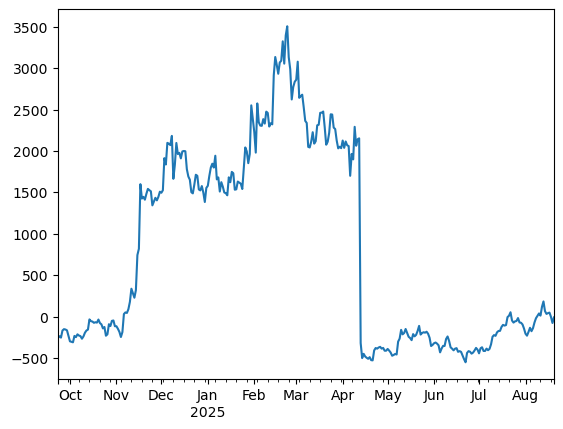

In [107]:
pnl_history['Total'].plot()

In [111]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:].cumsum()

2025-07-21     16.674338
2025-07-22     58.566044
2025-07-23    -41.019863
2025-07-24    -66.189285
2025-07-25    -51.577973
2025-07-26    -46.653821
2025-07-27    -11.529995
2025-07-28    -64.302994
2025-07-29    -68.038187
2025-07-30    -88.353308
2025-07-31   -138.121275
2025-08-01   -200.606115
2025-08-02   -224.266112
2025-08-03   -179.436893
2025-08-04   -128.996803
2025-08-05   -170.016857
2025-08-06   -133.603468
2025-08-07    -65.164201
2025-08-08    -13.078498
2025-08-09     15.560151
2025-08-10     44.140307
2025-08-11     18.014249
2025-08-12    124.425731
2025-08-13    189.466005
2025-08-14     72.521187
2025-08-15     38.732485
2025-08-16     48.148569
2025-08-17     54.334974
2025-08-18      2.923137
2025-08-19    -71.103023
2025-08-20     -3.347221
Name: Total, dtype: float64

In [87]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-371.0142984064944, -950.5160328166935)

In [46]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [47]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [48]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [49]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [50]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [51]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [52]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

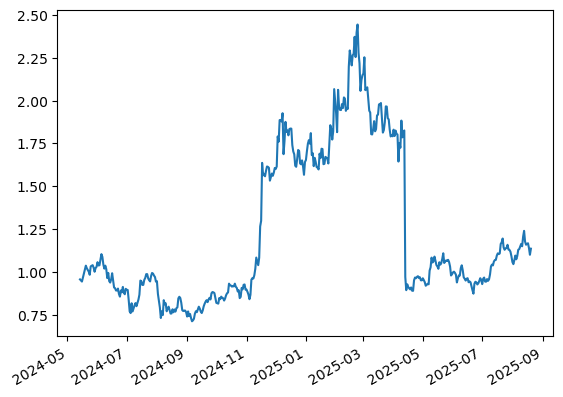

In [53]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

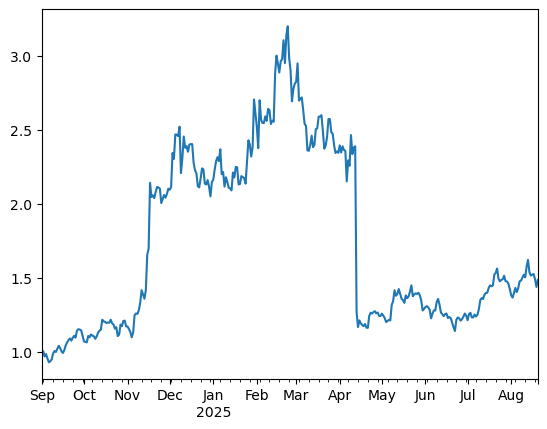

In [54]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [56]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [59]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [60]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.4199
TRXUSDT,0.2013
WBTCUSDT,0.1146
XRPUSDT,0.0963
BTCUSDT,0.0898
OMUSDT,0.0400
ADAUSDT,0.0382
BCHUSDT,0.0000
AVAXUSDT,0.0000
LTCUSDT,0.0000


In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.409746
WBTCUSDT,0.243319
TRXUSDT,0.200741
XRPUSDT,0.108783
OMUSDT,0.037411


In [65]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

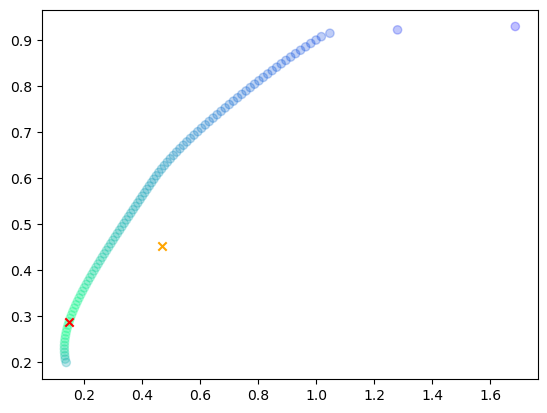

In [66]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [67]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [68]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1004.6336,0.4716,0.0185,0.4531
SOLUSDT,330.8202,0.1553,0.0000,0.1553
ETHUSDT,298.5117,0.1401,0.0000,0.1401
JASMYUSDT,196.4990,0.0922,0.0000,0.0922
TRXUSDT,171.3421,0.0804,0.0282,0.0522
OMUSDT,110.7685,0.0520,0.0051,0.0469
BNBUSDT,17.6503,0.0083,0.0570,-0.0487
BBUSDT,0.0016,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0020,-0.0020
PAXGUSDT,0.0000,0.0000,0.7425,-0.7425


### Current results

In [70]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [71]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.621423
TRXUSDT,0.378577


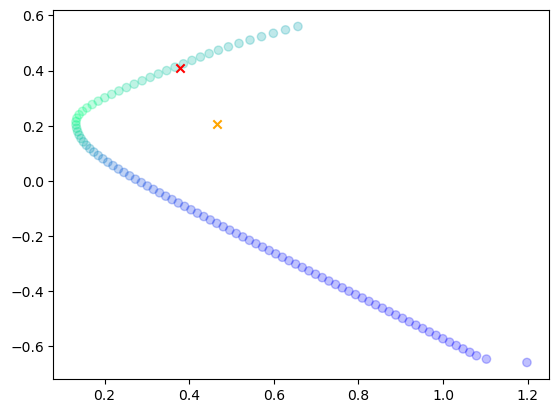

In [72]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [73]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1004.6336,0.4716,0.6214,-0.1498
SOLUSDT,330.8202,0.1553,0.0000,0.1553
ETHUSDT,298.5117,0.1401,0.0000,0.1401
JASMYUSDT,196.4990,0.0922,0.0000,0.0922
TRXUSDT,171.3421,0.0804,0.3786,-0.2981
OMUSDT,110.7685,0.0520,0.0000,0.0520
BNBUSDT,17.6503,0.0083,0.0000,0.0083
BBUSDT,0.0016,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [75]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [76]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

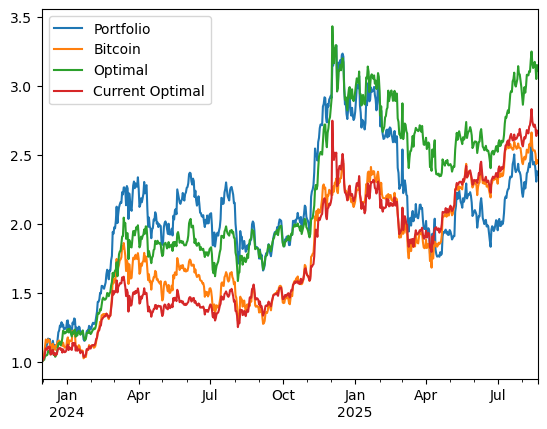

In [77]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [78]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

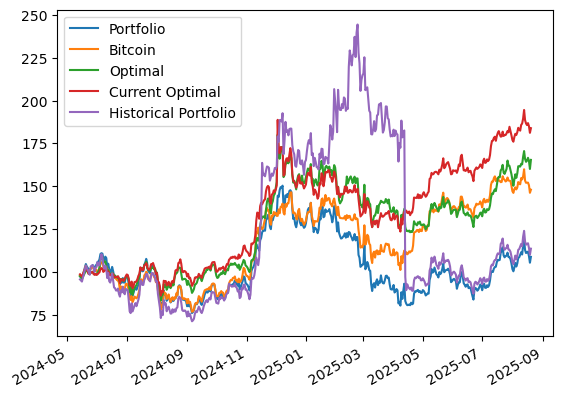

In [79]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [80]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-08-11,110.130381,153.956700,162.764639,186.583857,114.941611
2025-08-12,115.389917,155.823749,167.163978,189.489043,120.542351
2025-08-13,118.692653,159.885155,170.509703,194.506056,123.941736
2025-08-14,112.749786,153.251473,165.937711,188.549668,117.649222
2025-08-15,111.003556,152.011808,164.241310,186.616746,115.859840
2025-08-16,111.477605,152.061818,164.861344,185.686538,116.362675
2025-08-17,111.814228,152.093359,166.585573,186.833318,116.692229
2025-08-18,109.183285,150.559653,164.761098,185.039360,113.958771
2025-08-19,105.364534,146.150838,160.070774,181.150316,109.990348
2025-08-20,108.776190,147.950271,165.359616,183.864573,113.537707


## Volatilities

In [82]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.376093
 dtype: float64,
 0.3763896210505525)

In [83]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.466782
 dtype: float64,
 0.4667816088314955)

In [84]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.468552
Bitcoin            0.406780
Optimal            0.376390
Current Optimal    0.372400
dtype: float64

In [85]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5316087690869803

In [86]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-0.5096140216327273

<Axes: >

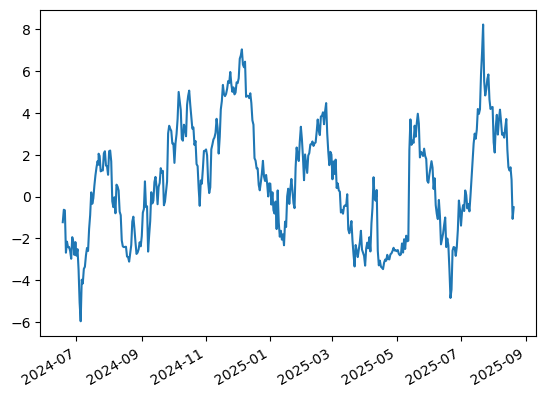

In [87]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [88]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.4437840325967537

## Risk Contribution

In [90]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,79.8837,0.4125,0.2294,0.1831
WBTCUSDT,35.3853,0.2038,0.0679,0.1360
TRXUSDT,27.2835,0.1876,0.0971,0.0906
XRPUSDT,18.1178,0.1299,0.0402,0.0897
OMUSDT,-34.9159,0.0662,0.0281,0.0381
Portfolio,125.7544,1.0000,0.4626,0.5374


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,37.850618,0.516375,0.432556,0.083819
BTCUSDT,35.723705,0.483625,0.399806,0.083819
Portfolio,73.574323,1.000000,0.832362,0.167638


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,27.018860,0.350715,0.150147,0.200569
TRXUSDT,7.998504,0.041554,0.012681,0.028873
ETHUSDT,0.748833,0.153980,0.032082,0.121898
BNBUSDT,0.239813,0.006636,0.000076,0.006560
SOLUSDT,-3.194027,0.209018,0.057059,0.151958
JASMYUSDT,-6.130602,0.158683,0.039915,0.118768
OMUSDT,-7.826082,0.079415,0.034584,0.044831
Portfolio,18.855300,1.000000,0.326543,0.673457


# Value At Risk

## Historical

### Optimal Weights

In [96]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.06427752124328709, -0.08086462973074081)

### Current Weights

In [98]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08010961504412652, -0.0976969727026095)

In [99]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [100]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.030910
SOLUSDT     -0.012757
ETHUSDT     -0.012150
JASMYUSDT   -0.015446
TRXUSDT     -0.003934
OMUSDT      -0.002842
BNBUSDT     -0.000670
BBUSDT      -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.078709
Name: 2025-03-09 00:00:00, dtype: float64

In [101]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025445
SOLUSDT     -0.019328
ETHUSDT     -0.013950
JASMYUSDT   -0.012175
TRXUSDT     -0.004212
OMUSDT      -0.018794
BNBUSDT     -0.000629
BBUSDT       0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.094532
dtype: float64

## Parametric

### Optimal Weights

In [104]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.05515844661843038, -0.06831734436367898)

### Current Weights

In [106]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.06840504363891332, -0.08472412130856911)

## Multivariate

### Optimal Weights

In [109]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05162355362927895, -0.06008668101096998)

### Current Weights

In [111]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06776657116911994, -0.07855141871634816)

In [112]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.022601
SOLUSDT     -0.013172
ETHUSDT     -0.010482
JASMYUSDT   -0.010641
TRXUSDT     -0.002641
OMUSDT      -0.007499
BNBUSDT     -0.000388
Portfolio   -0.067425
dtype: float64

In [113]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.021620
SOLUSDT     -0.013375
ETHUSDT     -0.010377
JASMYUSDT   -0.011452
TRXUSDT     -0.003360
OMUSDT      -0.007655
BNBUSDT     -0.000392
Portfolio   -0.068232
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [117]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0522875638517691, -0.060872115435761216)

### Current Weights

In [119]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06770334824199443, -0.07769789348257627)

In [120]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [123]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05372575780713293, -0.06343540171880306)

### Current Weights

In [125]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06903563783165256, -0.0785120028044185)

In [126]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [129]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0871905978886951, -0.10438104775433922)

### Current Weights

In [131]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08745717304630429, -0.10589244201170554)

In [132]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [135]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [136]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05501308837328786, -0.06412185457814806)

### Current Weights

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06873519819610922, -0.07716387816697304)

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [140]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.033074,-0.023793,-0.016799,-0.022601,-0.023927
SOLUSDT,-0.009383,-0.014219,-0.010407,-0.013172,-0.014325
ETHUSDT,-0.006189,-0.010803,-0.007385,-0.010482,-0.010896
JASMYUSDT,-0.004384,-0.010998,-0.008022,-0.010641,-0.010411
TRXUSDT,-0.000877,-0.002398,-0.002258,-0.002641,-0.002696
OMUSDT,-0.003387,-0.004970,-0.004080,-0.007499,-0.006545
BNBUSDT,0.000023,-0.000460,-0.000316,-0.000388,-0.000433
Portfolio,-0.057272,-0.067640,-0.049267,-0.067425,-0.069233


In [141]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.038994,-0.024741,-0.016860,-0.021620,-0.025156
SOLUSDT,-0.008386,-0.013754,-0.011125,-0.013375,-0.013706
ETHUSDT,-0.004374,-0.010792,-0.007282,-0.010377,-0.010546
JASMYUSDT,-0.002891,-0.010981,-0.008146,-0.011452,-0.010303
TRXUSDT,0.000099,-0.002881,-0.002167,-0.003360,-0.002791
OMUSDT,-0.003447,-0.004832,-0.003887,-0.007655,-0.007441
BNBUSDT,0.000025,-0.000451,-0.000317,-0.000392,-0.000422
Portfolio,-0.057966,-0.068432,-0.049784,-0.068232,-0.070365


## VaR Violation

In [143]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.030646,-0.040718,-0.034018,0.007387
2023-12-31,-0.030646,-0.040860,-0.034564,-0.001457
2024-01-01,-0.030646,-0.041015,-0.033801,0.015073
2024-01-02,-0.030646,-0.040945,-0.033738,0.005223
2024-01-03,-0.030646,-0.041713,-0.036999,-0.019390
...,...,...,...,...
2025-08-17,-0.027785,-0.040290,-0.037489,0.010459
2025-08-18,-0.027785,-0.040654,-0.037964,-0.010952
2025-08-19,-0.028385,-0.041267,-0.040436,-0.028467
2025-08-20,-0.028385,-0.043510,-0.043525,0.033041


In [144]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.024081,-0.077984,-0.070324,-0.015769
2024-05-29,-0.017409,-0.075934,-0.068874,-0.009004
2024-05-30,-0.017409,-0.064015,-0.057806,0.021868
2024-05-31,-0.017409,-0.062943,-0.056815,0.005073
2024-06-01,-0.017409,-0.061156,-0.055392,0.015092
...,...,...,...,...
2025-08-17,-0.045896,-0.056984,-0.047605,0.003020
2025-08-18,-0.046354,-0.058998,-0.055140,-0.023530
2025-08-19,-0.047956,-0.061730,-0.061513,-0.034976
2025-08-20,-0.047956,-0.062999,-0.059123,0.032380


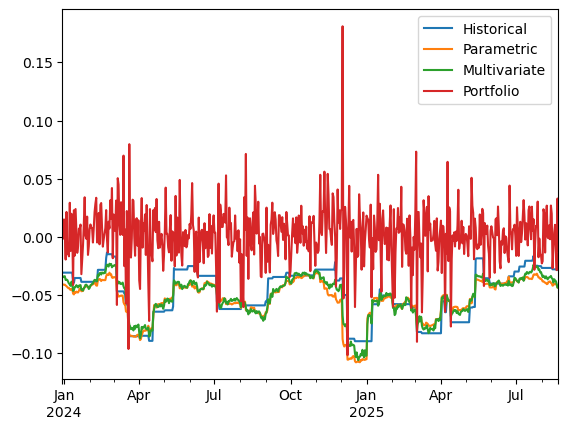

In [145]:
var_data.plot()
plt.show()

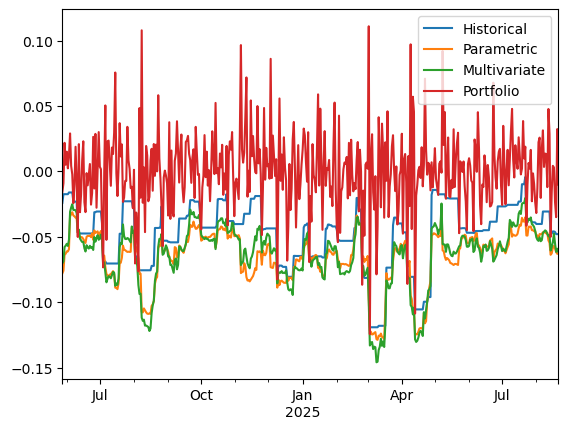

In [146]:
current_var_data.plot()
plt.show()


In [147]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031614,0.018303,0.018303
Kupiec Stat,4.892392,16.619376,16.619376
P-value,0.026975,0.000046,0.000046


In [148]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064302,0.017738,0.015521
Kupiec Stat,1.788115,13.007916,15.280111
P-value,0.181156,0.00031,0.000093


# Principal Component Analysis

## Historical PCA

In [151]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59285691, 0.22559237, 0.07580447, 0.0583727 , 0.04737355])

In [152]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.059560
AVAXUSDT     0.059955
BCHUSDT      0.045518
BNBUSDT      0.026611
BTCUSDT      0.030544
DOGEUSDT     0.062460
ETHUSDT      0.044373
HBARUSDT     0.060052
JASMYUSDT    0.069551
LINKUSDT     0.056148
LTCUSDT      0.042093
OMUSDT       0.067005
PAXGUSDT     0.000513
PEPEUSDT     0.079643
SOLUSDT      0.052712
SUIUSDT      0.058228
TRXUSDT      0.017428
USDCUSDT    -0.000155
WBETHUSDT    0.044377
WBTCUSDT     0.030335
XLMUSDT      0.047243
XRPUSDT      0.045807
Name: PC1, dtype: float64

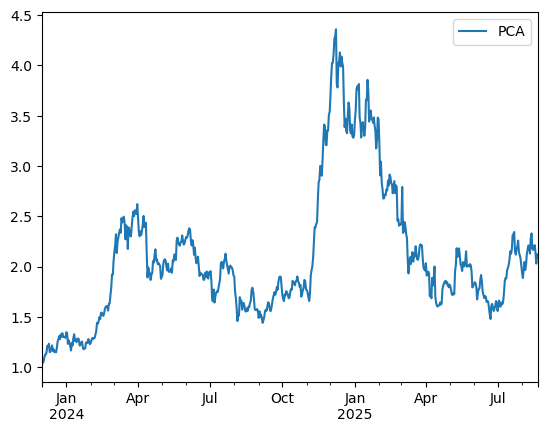

In [153]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

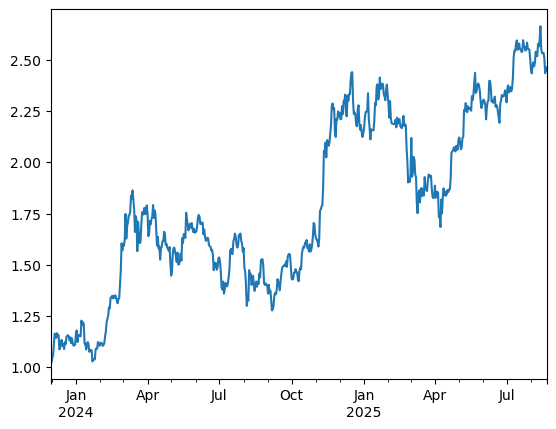

In [154]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [155]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.504883
ETHUSDT      0.505919
WBTCUSDT     0.552911
BTCUSDT      0.553619
AVAXUSDT     0.670540
SOLUSDT      0.674769
LINKUSDT     0.693875
DOGEUSDT     0.696466
BNBUSDT      0.711514
LTCUSDT      0.715477
ADAUSDT      0.734252
XRPUSDT      0.769472
BCHUSDT      0.835844
XLMUSDT      0.906113
USDCUSDT     0.952366
PAXGUSDT     0.965123
SUIUSDT      1.073730
TRXUSDT      1.084976
HBARUSDT     1.104373
dtype: float64

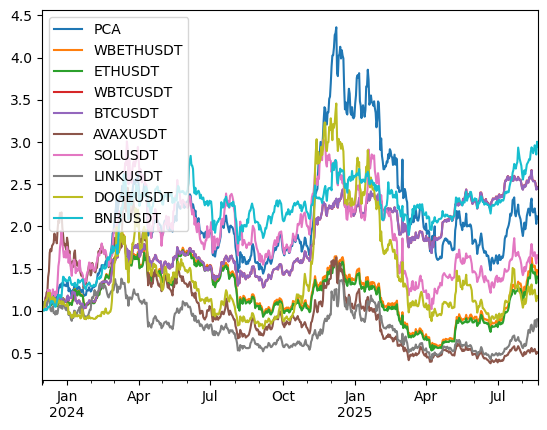

In [156]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

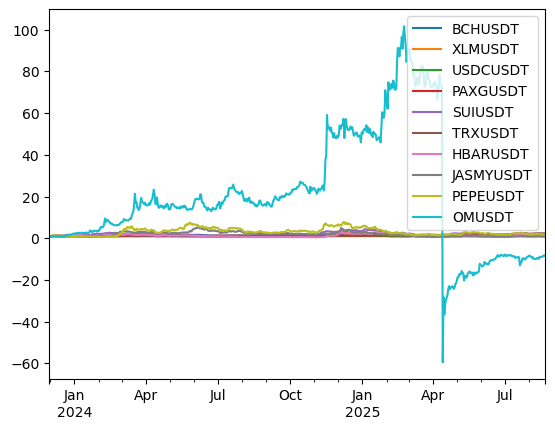

In [157]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [159]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52532897, 0.301385  , 0.06889656, 0.06313055, 0.04125893])

In [160]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049619
SOLUSDT      0.093365
ETHUSDT      0.081480
JASMYUSDT    0.141799
TRXUSDT      0.034426
OMUSDT       0.237938
BNBUSDT      0.051437
BBUSDT       0.171187
PEPEUSDT     0.137625
PAXGUSDT     0.001124
Name: PC1, dtype: float64

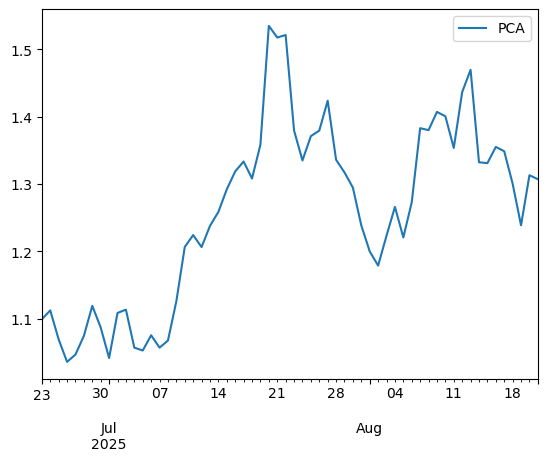

In [161]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

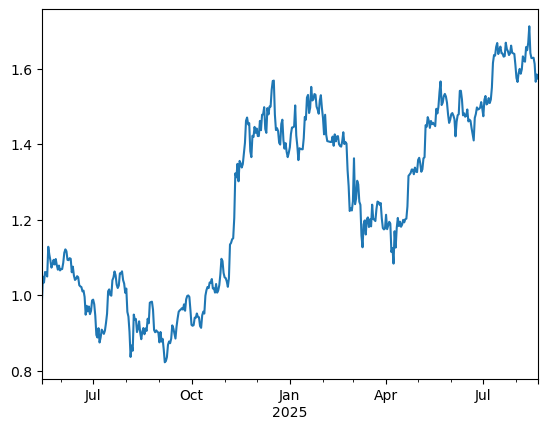

In [162]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.731361
SOLUSDT      0.770210
BTCUSDT      0.794296
BNBUSDT      0.796030
JASMYUSDT    0.973045
PEPEUSDT     1.007982
PAXGUSDT     1.059304
BBUSDT       1.082983
TRXUSDT      1.176385
dtype: float64

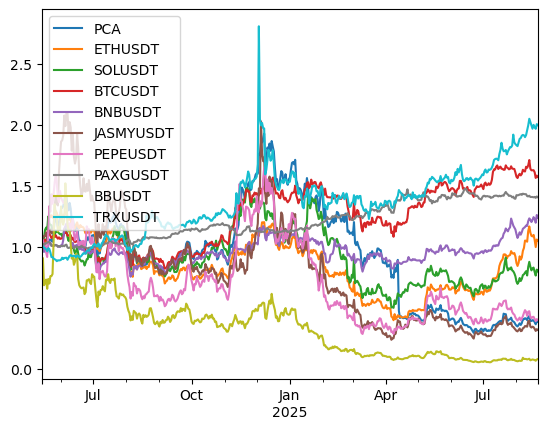

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [166]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.919873
BBUSDT       1.647770
JASMYUSDT    1.471496
SOLUSDT      1.288912
ETHUSDT      1.098033
BTCUSDT      1.000000
OMUSDT       0.995774
BNBUSDT      0.665511
TRXUSDT      0.332390
PAXGUSDT     0.029196
Name: BTCUSDT, dtype: float64

In [167]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       4.322875
JASMYUSDT    2.445185
PEPEUSDT     2.065882
SOLUSDT      1.977360
ETHUSDT      1.877795
OMUSDT       1.717103
BNBUSDT      1.086429
BTCUSDT      1.000000
TRXUSDT      0.510415
PAXGUSDT     0.092637
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [169]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [170]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.214652
BNBUSDT,0.187380
PEPEUSDT,0.182553
OMUSDT,0.148528
JASMYUSDT,0.121678
PAXGUSDT,0.107948
TRXUSDT,0.081377
SOLUSDT,0.079646
BBUSDT,0.040891
BTCUSDT,-0.019642


### Regression to PCA

In [172]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.4626710479047835

In [173]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.315704
BNBUSDT      1.126312
PCA          1.000000
ETHUSDT      0.878488
SOLUSDT      0.725370
JASMYUSDT    0.464384
PEPEUSDT     0.459215
BBUSDT       0.367821
TRXUSDT      0.283871
PAXGUSDT     0.246033
OMUSDT       0.156420
dtype: float64

In [174]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.899159
PAXGUSDT     1.667789
BNBUSDT      1.257468
PCA          1.000000
TRXUSDT      0.968890
ETHUSDT      0.886787
SOLUSDT      0.870807
PEPEUSDT     0.740066
JASMYUSDT    0.665079
OMUSDT       0.655248
BBUSDT       0.283680
dtype: float64

### Correlation Matrix

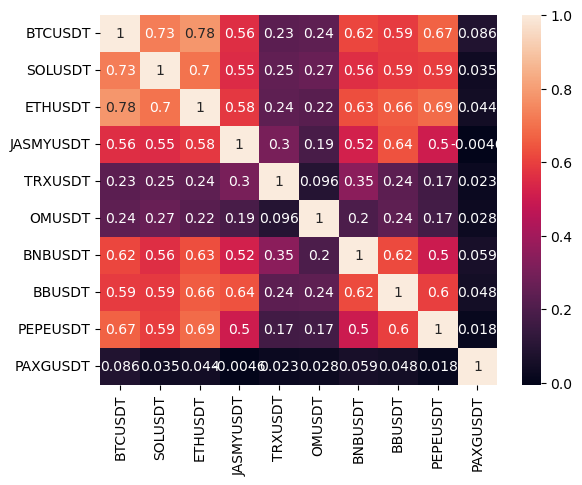

In [176]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

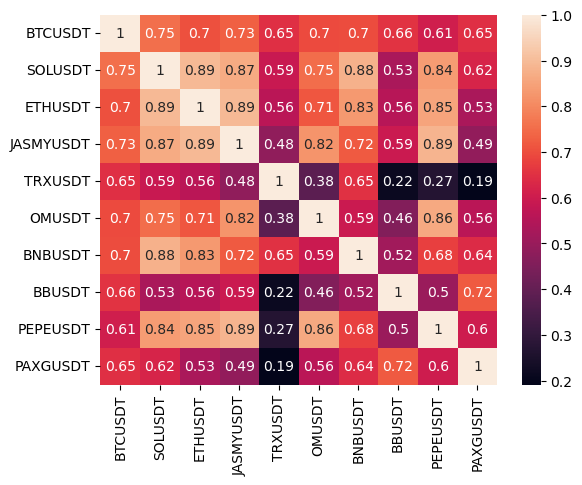

In [177]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [178]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [179]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

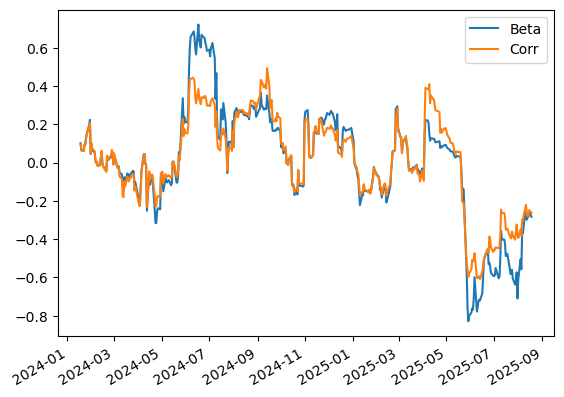

In [180]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [182]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BNBUSDT,BBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.000000,0.003604,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526887,0.176734,0.000000,0.000000,0.130357,0.000000


In [183]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [184]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,ADAUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,JASMYUSDT,LINKUSDT,...,PAXGUSDT,PEPEUSDT,SOLUSDT,SUIUSDT,TRXUSDT,USDCUSDT,WBETHUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
2025-01-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.761799,0.0,0.000000,0.111228,0.000000,0.0,0.000000,0.000000,0.000000,0.126972
2025-02-12,0.000000,0.000000,0.000000,0.012192,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.956052,0.0,0.000476,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-03-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.909521,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-04-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000259,0.000000,...,0.661326,0.0,0.000000,0.000000,0.338416,0.0,0.000000,0.000000,0.000000,0.000000
2025-05-13,0.000000,0.000000,0.000000,0.000000,0.034044,0.0,0.013515,0.0,0.000000,0.000000,...,0.475024,0.0,0.048527,0.062361,0.000000,0.0,0.116095,0.169228,0.000000,0.000000
2025-06-12,0.000000,0.000000,0.114887,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.830482,0.0,0.000000,0.000000,0.054631,0.0,0.000000,0.000000,0.000000,0.000000
2025-07-12,0.000000,0.000000,0.183448,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.685043,0.0,0.000000,0.000000,0.131508,0.000000
2025-08-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.060602,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.495196,0.0,0.320830,0.000000,0.000000,0.000000
2025-08-21,0.090657,0.006787,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.902556,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [185]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

TRXUSDT      0.495196
WBETHUSDT    0.320830
LTCUSDT      0.123373
ETHUSDT      0.060602
ADAUSDT      0.000000
PAXGUSDT     0.000000
Name: 2025-08-11 00:00:00, dtype: float64

<Axes: >

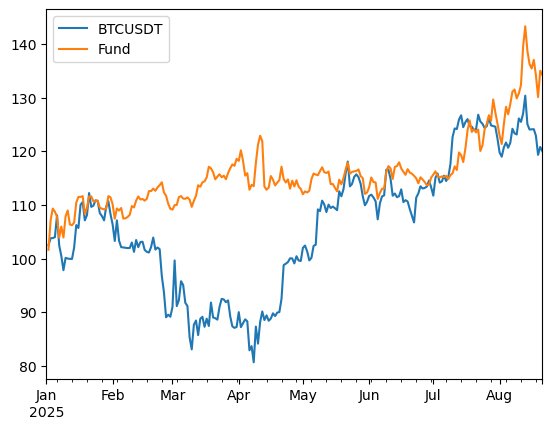

In [186]:
q=rebalanced_dynamic_quantities(data[returns_to_use.columns],rolling_optimization)
ptf=q*data[returns_to_use.columns]
comparison=pd.DataFrame()
comparison['BTCUSDT']=data['BTCUSDT']
comparison['Fund']=ptf.sum(axis=1)
((1+comparison.loc['2025'].pct_change()).cumprod()*100).plot()

In [187]:
(ptf-rebalanced_book_cost(data[returns_to_use.columns],q)).iloc[-1].sort_values(ascending=False)

PAXGUSDT     70.259116
SUIUSDT      67.254467
XRPUSDT      39.537859
TRXUSDT      36.394024
BCHUSDT      12.769523
XLMUSDT       3.338246
WBETHUSDT     1.713959
WBTCUSDT      0.690684
ETHUSDT       0.306340
BTCUSDT       0.135659
JASMYUSDT     0.020587
PEPEUSDT      0.000000
USDCUSDT      0.000000
ADAUSDT       0.000000
AVAXUSDT      0.000000
LINKUSDT      0.000000
HBARUSDT      0.000000
DOGEUSDT      0.000000
BNBUSDT      -0.481832
SOLUSDT      -2.234563
LTCUSDT      -5.131879
OMUSDT      -18.970496
Name: 2025-08-21 00:00:00, dtype: float64

In [188]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
